In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from decouple import config
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense, Dropout



In [2]:
csv_path = config("CSV_PATH")

In [3]:
df = pd.read_csv(csv_path)

In [4]:
df.head()

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t191,t192,t193,t194,t195,t196,t197,t198,t199,Classes
0,24.00,24.00,23.00,25.00,24.00,25.00,24.00,24.00,22.00,25.00,...,1.00,-1.00,1.00,-1.00,1.00,0.00,1.00,0.00,0.00,1
1,23.00,23.00,22.00,21.00,21.00,22.00,23.00,23.00,22.00,21.00,...,-1.00,1.00,0.00,1.00,-1.00,0.00,-1.00,1.00,0.00,1
2,-0.55,-0.55,-0.55,3.45,13.45,11.45,18.45,18.45,20.45,20.45,...,-0.55,0.45,-0.55,0.45,-0.55,0.45,-0.55,0.45,-0.55,1
3,12.30,10.30,15.30,15.30,16.30,15.30,17.30,16.30,17.30,15.30,...,-0.70,0.30,-0.70,0.30,-0.70,1.30,-0.70,1.30,-0.70,1
4,24.85,2.85,5.85,-1.15,2.85,-1.15,1.85,-1.15,0.85,-1.15,...,-0.15,0.85,-1.15,-0.15,-1.15,0.85,-0.15,0.85,-0.15,2


In [5]:
features = df.drop("Classes", axis= 1)
target = df["Classes"]

In [6]:
target_dummies = pd.get_dummies(target)

In [7]:
scaler = StandardScaler()

In [8]:
df_scaled = scaler.fit_transform(features)

### PCA

In [9]:
pca = PCA()
pca.fit(df_scaled)

PCA()

In [10]:
pca.n_components_

100

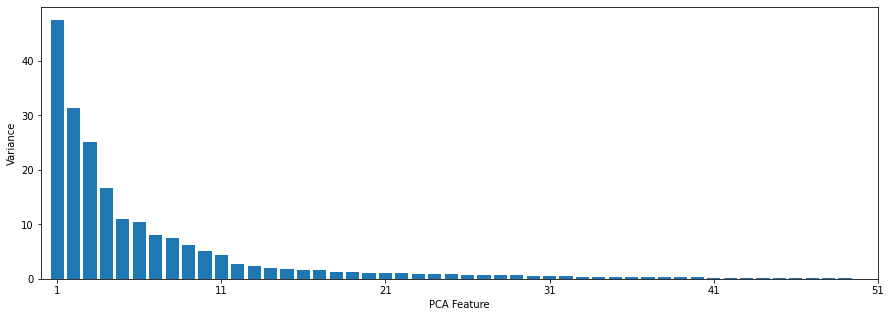

In [11]:
plt.figure(figsize=(15,5))
plt.bar(np.arange(1, 101), pca.explained_variance_)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.xticks(range(1, 101, 10))
plt.xlim(0,51)
plt.show()

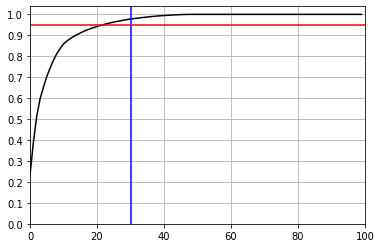

In [12]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='black')
plt.xlim(0,100)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(30, c='b')
plt.axhline(0.95, c='r')
plt.grid()
plt.show()

In [13]:
pca = PCA(n_components=22)
df_pca = pca.fit_transform(df_scaled)

### Neural Network without PCA

In [23]:
x_train, x_test, y_train, y_test = train_test_split(df_scaled, target_dummies,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=target_dummies)

In [25]:
n_features = x_train.shape[1]

In [17]:
n_features

200

In [32]:
model = Sequential()
model.add(Input(shape=(n_features,)))
model.add(Dropout(0.25))
model.add(Dense(n_features, activation="tanh"))
model.add(Dense(128, activation="tanh"))
model.add(Dense(7, activation="softmax"))

In [33]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [34]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_3 (Dropout)         (None, 200)               0         
                                                                 
 dense_8 (Dense)             (None, 200)               40200     
                                                                 
 dense_9 (Dense)             (None, 128)               25728     
                                                                 
 dense_10 (Dense)            (None, 7)                 903       
                                                                 
Total params: 66,831
Trainable params: 66,831
Non-trainable params: 0
_________________________________________________________________


In [35]:
hist = model.fit(x_train, y_train, epochs=30, validation_data=(x_test, y_test))

Epoch 1/30
3/3 [==============================] - 1s 81ms/step - loss: 2.1009 - accuracy: 0.1143 - val_loss: 1.3887 - val_accuracy: 0.6000
Epoch 2/30
3/3 [==============================] - 0s 14ms/step - loss: 1.3105 - accuracy: 0.5429 - val_loss: 1.0467 - val_accuracy: 0.7333
Epoch 3/30
3/3 [==============================] - 0s 14ms/step - loss: 0.9669 - accuracy: 0.6857 - val_loss: 0.9105 - val_accuracy: 0.7333
Epoch 4/30
3/3 [==============================] - 0s 20ms/step - loss: 0.7550 - accuracy: 0.8143 - val_loss: 0.8374 - val_accuracy: 0.7333
Epoch 5/30
3/3 [==============================] - 0s 19ms/step - loss: 0.6936 - accuracy: 0.8286 - val_loss: 0.7462 - val_accuracy: 0.8333
Epoch 6/30
3/3 [==============================] - 0s 17ms/step - loss: 0.5935 - accuracy: 0.8714 - val_loss: 0.6712 - val_accuracy: 0.8667
Epoch 7/30
3/3 [==============================] - 0s 55ms/step - loss: 0.5155 - accuracy: 0.8429 - val_loss: 0.6306 - val_accuracy: 0.8667
Epoch 8/30
3/3 [===========

In [36]:
loss, acc = model.evaluate(x_train, y_train, verbose=0)
print("Train loss:", loss)
print("Train acc:", acc)

Train loss: 0.027323367074131966
Train acc: 1.0


In [37]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", loss)
print("Test acc:", acc)

Test loss: 0.22501493990421295
Test acc: 0.9333333373069763


### Neural Network with PCA

In [38]:
x_train, x_test, y_train, y_test = train_test_split(df_pca, target_dummies,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=target_dummies)

In [39]:
n_features = x_train.shape[1]

In [40]:
n_features

22

In [31]:
model = Sequential()
model.add(Input(shape=(n_features,)))
model.add(Dropout(0.30))
model.add(Dense(n_features, activation="relu"))
model.add(Dense(, activation=))
model.add(Dense(7, activation="softmax"))

In [32]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 22)                0         
                                                                 
 dense_4 (Dense)             (None, 22)                506       
                                                                 
 dense_5 (Dense)             (None, 7)                 161       
                                                                 
Total params: 667
Trainable params: 667
Non-trainable params: 0
_________________________________________________________________


In [34]:
hist = model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))

Epoch 1/30
3/3 [==============================] - 1s 79ms/step - loss: 3.6030 - accuracy: 0.2000 - val_loss: 2.9148 - val_accuracy: 0.1333
Epoch 2/30
3/3 [==============================] - 0s 11ms/step - loss: 3.4268 - accuracy: 0.1857 - val_loss: 2.8347 - val_accuracy: 0.1333
Epoch 3/30
3/3 [==============================] - 0s 14ms/step - loss: 3.4162 - accuracy: 0.1429 - val_loss: 2.7625 - val_accuracy: 0.1333
Epoch 4/30
3/3 [==============================] - 0s 17ms/step - loss: 3.1036 - accuracy: 0.1429 - val_loss: 2.6890 - val_accuracy: 0.1333
Epoch 5/30
3/3 [==============================] - 0s 14ms/step - loss: 2.8238 - accuracy: 0.2143 - val_loss: 2.6166 - val_accuracy: 0.1333
Epoch 6/30
3/3 [==============================] - 0s 14ms/step - loss: 2.9322 - accuracy: 0.1286 - val_loss: 2.5476 - val_accuracy: 0.1333
Epoch 7/30
3/3 [==============================] - 0s 14ms/step - loss: 2.9633 - accuracy: 0.1429 - val_loss: 2.4790 - val_accuracy: 0.1667
Epoch 8/30
3/3 [===========

In [35]:
loss, acc = model.evaluate(x_train, y_train, verbose=0)
print("Train loss:", loss)
print("Train acc:", acc)

Train loss: 1.258591651916504
Train acc: 0.6000000238418579


In [36]:
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", loss)
print("Test acc:", acc)

Test loss: 1.4677164554595947
Test acc: 0.46666666865348816
